Elaborado por:
* Jose Guillermo Gordillo Lopez - 23003971
* René Ronaldo Godoy Mejía - 23005126
* Marvin Fernando Carrillo Robles - 14003303

# Problema 1 - Word Cloud:
Descargue el Dataset (https://drive.google.com/file/d/1iZBayycqiStE2OI4iRjqsTolrqh2YFq8/view?usp=sharing) el cual contiene aproximadamente 800,000 tweets de diversos temas.

Usando CoLab y expresiones regulares. Determine los 3 usuarios más populares dentro del dataset. Luego arme un corpus el cual contenga los siguientes elementos por cada usuario seleccionado:

Content: Tweet.

Metadata: ID, Timestamp, Length (este valor hay que calcularlo).

Posterior a tener sus 3 corpus creados, responda: ¿Razón por la que citan a ese usuario? para esto es necesario que extraiga el contexto de cada tweet y verifique cuales son las palabras que más rodean al nombre de usuario. Para extraer un contexto valido y debido a la naturaleza del tipo de datos que están disponibles en nuestro dataset le recomendamos seguir los siguientes pasos:

1. Remover stopwords.
2. Realizar stemming y lemmatización.
3. Mostrar un wordcloud con el top 10 para cada usuario.

### Importamos todas las librerias necesarias

In [39]:
import pandas as pd
import numpy as np
from collections import Counter
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re


### Cargamos el modelo de spacy en inglés

In [40]:
!python -m spacy download en_core_web_md
import spacy
nlp = spacy.load("en_core_web_md")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 16.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Conexión con Drive para acceder a datos.

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Lectura de Datos


In [42]:
dataset = pd.read_csv('/content/drive/MyDrive/Text Mining & Image Recognition /Problema 1 - Word Cloud/tw_source.csv',
                      encoding='Latin_1', header=None)
dataset.columns = ['Valor', 'Id', 'fecha', 'fuente', 'usuario', 'tweet']

dataset.head()

,Valor,Id,fecha,fuente,usuario,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [28]:
dataset.shape

(1600000, 6)

### Creamos la lista de menciones

In [29]:
lista_menciones = []
filas_per_at = {}
cont = 0

for tweet in dataset['tweet']:
    ats_in_tweet = [palabra for palabra in tweet.split(' ') if '@' in palabra]
    lista_menciones.extend(ats_in_tweet)

    try:
        ultimo_at = ats_in_tweet[len(ats_in_tweet) - 1]
        filas_per_at.setdefault(ultimo_at, []).append(cont)
    except:
        pass
    finally:
        cont = cont + 1


### Contamos las menciones y obtenemos los tres usuarios más mencionados o populares

In [30]:
contador_menciones = Counter(lista_menciones)
usuarios_mas_populares = contador_menciones.most_common(4)[1:]
print(usuarios_mas_populares)

[('@mileycyrus', 4310), ('@tommcfly', 3837), ('@ddlovato', 3349)]


### Creamos el corpus para cada usuario

In [31]:
def crear_corpus(usuario):
    filas_usuario = filas_per_at[usuario]
    corpus_usuario = dataset.iloc[filas_usuario, [1, 2, 5]].copy()  # Con esto vamos a copiar el ID, timestamp, y tweet
    corpus_usuario['Length'] = corpus_usuario['tweet'].apply(len)  # y con esto vamos a calcular el length de cada tweet
    return corpus_usuario

corpus_mileycyrus = crear_corpus('@mileycyrus')
corpus_tommcfly = crear_corpus('@tommcfly')
corpus_ddlovato = crear_corpus('@ddlovato')


### Definimos los stopwords

In [56]:
stopwords_custom = set(stopwords.words('english')) | set(stopwords.words('spanish'))
stopwords_custom.update(["i", "u", "im", "youre", "dont", "cant"])  # Escogimos estas porque vimos que estas son las que más se repiten

def limpiar_texto(texto, usuario, min_freq=5):

    # Descargamos stopwords para mayor seguridad de que no se nos escape ninguno
    nltk.download('stopwords', quiet=True)

    # Debido a la naturaleza del dataset, vamos a elimiar menciones, hashtags, URLs y otros patrones comunes para que no nos afecto nuestro word clouds
    texto = re.sub(r'@\w+', '', texto)
    texto = re.sub(r'#\w+', '', texto)
    texto = re.sub(r'http\S+', '', texto)

    # Aca procedemos a tokenizar y lematizar
    doc = nlp(texto)

    # Filtramos los tokens basados en condiciones
    tokens_limpios = [token.lemma_.lower() for token in doc if
                      token.pos_ in ["NOUN", "ADJ", "VERB", "ADV"] and  # Filtramos por partes del tweet o contenido
                      len(token.text) > 2 and  # Eliminamos tokens de una o dos letras que no nos aportaran nada en nuestros wordclouds
                      token.text.isalpha() and
                      token.lemma_ not in stopwords_custom and
                      not token.is_punct]

    return ' '.join(tokens_limpios)


### Limpiamos los textos en cada corpus

In [59]:
corpus_mileycyrus['Content'] = corpus_mileycyrus['tweet'].apply(lambda x: limpiar_texto(x, '@mileycyrus'))
corpus_tommcfly['Content'] = corpus_tommcfly['tweet'].apply(lambda x: limpiar_texto(x, '@tommcfly'))
corpus_ddlovato['Content'] = corpus_ddlovato['tweet'].apply(lambda x: limpiar_texto(x, '@ddlovato'))

### Generamos el word clouds con el top 20 de las palabras, esto debido a que el top10 no nos daba una idea muy clara de que es lo que más estaban tuiteando sobre el usuario, por eso optamos a dejarlo en 20


In [73]:
def generar_wordcloud(texto, usuario):
    # Creamos un Counter con las palabras del texto
    word_freq = Counter(texto.split())

    # Filtramos el top 20 de las palabras
    top_words = dict(word_freq.most_common(20))

    # Creamos el WordCloud solo con las top 20 palabras
    wordcloud = WordCloud(background_color='white', width=800, height=400,
                        max_words=20, contour_color='steelblue').generate_from_frequencies(top_words)

    # Mostramos el WordCloud
    plt.figure(figsize=(8, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud para {usuario}")
    plt.show()

### Generar los WordClouds para cada usuario

In [77]:
texto_mileycyrus = ' '.join(corpus_mileycyrus['Content'])
texto_tommcfly = ' '.join(corpus_tommcfly['Content'])
texto_ddlovato = ' '.join(corpus_ddlovato['Content'])

### Word Cloud para @mileycyrus

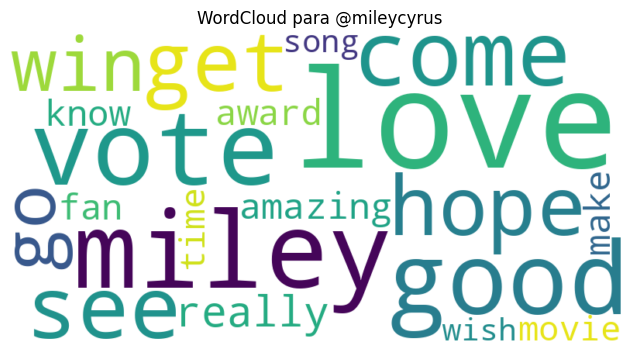

In [78]:
generar_wordcloud(texto_mileycyrus, '@mileycyrus')

#### ¿Cuál es la razón por la que citan a este usuario?

La razón por la que más citan a @mileycyrus es por su nombre, por votos, por amor, esperanza, el wordcloud da la idea de que las personas citan a Miley y hacen mención a que ella es una ganadora, asombrosa, también algunas palabras podrían refererirse a letras en sus canciones y a los diversos premios que Miley Cyrus ha ganado.

### Word Cloud para @tommcfly

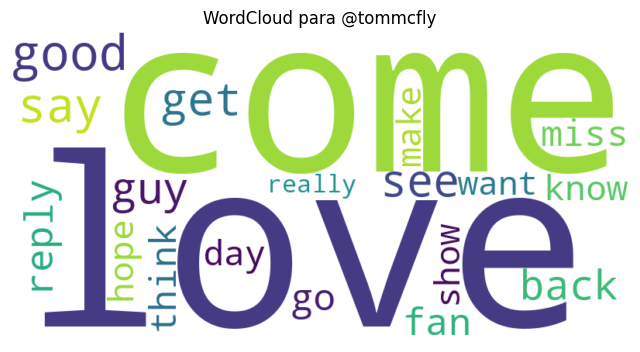

In [75]:
generar_wordcloud(texto_tommcfly, '@tommcfly')


#### ¿Cuál es la razón por la que citan a este usuario?

La razón por la que citan a @tommcfly es por palabras como amor, venir, bueno, extrañar, regresar, responder, show, fan, hacer, lo cual podría decirse que es consistente con Tom Fletcher, quien es un músico y compositor británico cofundador de la banda británica McFly

### Word Cloud para @ddlovato

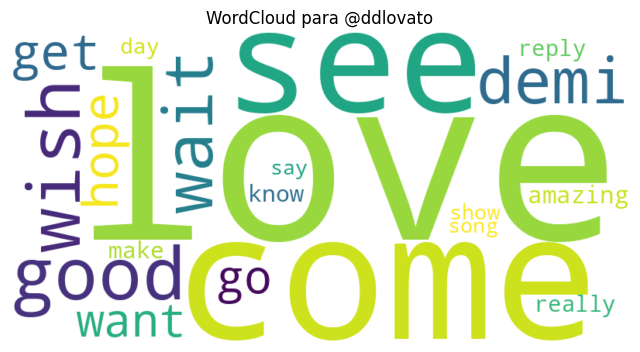

In [76]:
generar_wordcloud(texto_ddlovato, '@ddlovato')

#### ¿Cuál es la razón por la que citan a este usuario?

Las razones por la que citan a @ddlovato principalmente es por "amor", lo cual es consistente con el nombre de una se sus canciones llamada "I love me", asi mismo las personas la citan por lo asombrosa que es, por los shows que da, y también por el nombre corto de la cantante, el cual es Demi. Adicionalmente, la citan por lo buena que es y por deseos, posiblemente son personas que desean conocerla o ir a unos de sus shows o conciertos.